# Cart Pole Policy Gradient Solution
![mc_pg](../images/lecture_4/mc_pg.png)

## Import Env


In [1]:
import gymnasium as gym
from gymnasium.envs.classic_control.cartpole import CartPoleEnv
for k, v in gym.envs.registry.items():
    print(str(k)+"\t"+str(v))


CartPole-v0	EnvSpec(id='CartPole-v0', entry_point='gymnasium.envs.classic_control.cartpole:CartPoleEnv', reward_threshold=195.0, nondeterministic=False, max_episode_steps=200, order_enforce=True, autoreset=False, disable_env_checker=False, apply_api_compatibility=False, kwargs={}, namespace=None, name='CartPole', version=0, additional_wrappers=(), vector_entry_point='gymnasium.envs.classic_control.cartpole:CartPoleVectorEnv')
CartPole-v1	EnvSpec(id='CartPole-v1', entry_point='gymnasium.envs.classic_control.cartpole:CartPoleEnv', reward_threshold=475.0, nondeterministic=False, max_episode_steps=500, order_enforce=True, autoreset=False, disable_env_checker=False, apply_api_compatibility=False, kwargs={}, namespace=None, name='CartPole', version=1, additional_wrappers=(), vector_entry_point='gymnasium.envs.classic_control.cartpole:CartPoleVectorEnv')
MountainCar-v0	EnvSpec(id='MountainCar-v0', entry_point='gymnasium.envs.classic_control.mountain_car:MountainCarEnv', reward_threshold=-110.

In [2]:
env = gym.make("CartPole-v1")
print("Observation space: ", env.observation_space)
print("Observation shape: ",env.observation_space.shape)
print("Action space: ", env.action_space)

Observation space:  Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)
Observation shape:  (4,)
Action space:  Discrete(2)


## Normalizer

In [3]:
import numpy as np


def normalizer(env: gym.Env, state: np.ndarray):
    LOW = np.asarray(env.observation_space.low, dtype=np.float64)
    HIGH = np.asarray(env.observation_space.high, dtype=np.float64)
    normalized_state = np.zeros(state.shape)
    normalized_state = (state-LOW)/(HIGH - LOW)
    normalized_state = normalized_state.astype(np.float32)
    return normalized_state

normalizer(env,env.reset()[0])


array([0.50290364, 0.5       , 0.47963864, 0.5       ], dtype=float32)

## Memory

In [4]:
from collections import namedtuple
Transtion=namedtuple("Transition",["action_log_prob","reward"])

## Actor

In [5]:
import torch
import torch.nn as nn
import torch.distributions as distributions
import torch.nn.functional as F


class Actor(nn.Module):
    def __init__(self, num_observations: int, num_actions: int) -> None:
        super().__init__()
        self.linear_1 = nn.Linear(num_observations, 128)
        self.linear_2 = nn.Linear(128, num_actions)
        self.selu = nn.SELU()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        action_value = self.linear_1(x)
        action_value = self.selu(action_value)
        action_value = self.linear_2(action_value)
        return action_value


distributions.Categorical(F.softmax(Actor(env.observation_space.shape[0], env.action_space.n)(
    torch.tensor(normalizer(env, env.reset()[0]))), dim=-1)).sample()


tensor(1)

In [6]:
from typing import List
def update_actor(optimizer: torch.optim.Optimizer, memory: List[Transtion], discount_factor: float, device: str):
    action_log_probs,rewards=zip(*memory)
    action_log_probs=torch.cat(action_log_probs)
    
    g_array=[]
    g=0.0
    for reward in reversed(rewards):
        g=reward+discount_factor*g
        g_array.append(g)
    g_array=list(reversed(g_array))
    g_array=torch.tensor(g_array,dtype=torch.float32,device=device)
    # trick here
    g_array=(g_array-g_array.mean())/(g_array.std())
    
    
    optimizer.zero_grad()
    loss=-torch.sum(g_array*action_log_probs)
    loss.backward()
    optimizer.step()
            
    

In [7]:
from collections import defaultdict
from typing import Tuple, Dict


def policy_gradient(env: gym.Env, num_episodes: int = 1000, learing_rate: float = 1e-3, discount_factor: float = 0.9, device: str = "cpu", print_step=100) -> Tuple[Actor, Dict]:
    actor = Actor(
        env.observation_space.shape[0], env.action_space.n).to(device)
    optimizer = torch.optim.Adam(actor.parameters(), lr=learing_rate)

    num_durations_per_episode = defaultdict(float)

    for episode_i in range(num_episodes):
        memory = []
        state = env.reset()[0]
        is_terminated = False
        while not is_terminated:
            # state_normalized = normalizer(env, state)
            state_tensor = torch.tensor(
                state, dtype=torch.float32, device=device)
            action_value = actor(state_tensor)
            action_prob = F.softmax(action_value, dim=-1)
            action_distribution = distributions.Categorical(action_prob)
            action = action_distribution.sample()
            action_log_prob = action_distribution.log_prob(action)
            action_log_prob = torch.reshape(action_log_prob, (-1,))
            state, reward, is_terminated, is_truncated, info = env.step(
                action.item())
            if is_terminated:
                reward = 0.0
            memory.append(Transtion(action_log_prob, reward))

            num_durations_per_episode[episode_i] += reward

        update_actor(optimizer, memory, discount_factor, device)

        if episode_i % print_step == 0:
            print("episode %d, reward %d" %
                  (episode_i, num_durations_per_episode[episode_i]))

    return actor, num_durations_per_episode


In [8]:
pg_actor, pg_num_durations_per_episode = policy_gradient(
    env, num_episodes=int(1e3), learing_rate=1e-3, discount_factor=0.9, device="cuda" if torch.cuda.is_available() else "cpu", print_step=100)


episode 0, reward 14
episode 100, reward 24
episode 200, reward 126
episode 300, reward 544
episode 400, reward 244
episode 500, reward 296
episode 600, reward 275
episode 700, reward 214
episode 800, reward 495
episode 900, reward 168


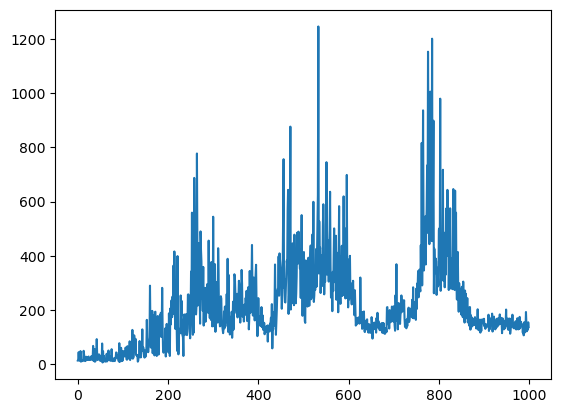

In [9]:
import matplotlib.pyplot as plt
def plot_num_durations_per_episode(num_durations_per_episode:Dict):
    fig,ax=plt.subplots()
    ax.plot(num_durations_per_episode.keys(),num_durations_per_episode.values())
plot_num_durations_per_episode(pg_num_durations_per_episode)

In [10]:
torch.save(pg_actor.state_dict(),"saves/CartPole-v1-pg.pth")